In [1]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras import layers, models
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from emnist import extract_training_samples,extract_test_samples
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

## Table of content

- Load MNIST trained model (Base model)
- Evaluate on MNIST
- Clone base model (new model)
- Upload EMNIST 36 data
- Evaluate first without transfer learning
- fine-tune new model on EMNSIT small data
- Evaluate again 
- Compare performance with a model trained from scratch on the same EMNIST small data

- **Load MNIST trained model**

In [2]:
#Reading the model from JSON file
with open('saved_model/MNIST_trained.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture 
base_model = tf.keras.models.model_from_json(json_savedModel)
base_model.summary()
# Load weights
base_model.load_weights('saved_model/MNIST_trained_weights.h5')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        21952     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 5408)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                54090     
                                                                 
Total params: 76,042
Trainable params: 76,042
Non-trainable params: 0
_________________________________________________________________


- **Evaluate first on MNIST dataset**

In [57]:
# Load and preprocess the MNIST dataset
(MNIST_train, MNIST_train_labels), (MNIST_test, MNIST_test_labels) = mnist.load_data()
# One-hot encode the labels
MNIST_train_labels = to_categorical(MNIST_train_labels)
MNIST_test_labels = to_categorical(MNIST_test_labels)

In [58]:
# Compile the model
base_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
# Evaluate the model on the test set
mnist_loss, mnist_acc = base_model.evaluate(MNIST_test, MNIST_test_labels, verbose=0)
print(f'MNIST accuracy: {round(mnist_acc*100,2)} %')

MNIST accuracy: 97.14 %


- **Cloning Base model**

In [60]:
# Clone the model (including architecture and weights)
new_model = tf.keras.models.clone_model(base_model)
new_model.set_weights(base_model.get_weights())
new_model.pop()     # Removing output layer
new_model.add(layers.Dense(36, activation = 'softmax', name = 'emnist_output_layer'))
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        21952     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 5408)              0         
                                                                 
 emnist_output_layer (Dense)  (None, 36)               194724    
                                                                 
Total params: 216,676
Trainable params: 216,676
Non-trainable params: 0
_________________________________________________________________


- **Uploading formatted emnist 36 classes data**


In [61]:
emnist_train = np.load('data/emnist36_train.npy')
emnist_train_labels = np.load('data/emnist36_train_labels.npy')
emnist_test = np.load('data/emnist36_test.npy')
emnist_test_labels = np.load('data/emnist36_test_labels.npy')
# One-hot encode the labels
emnist_train_labels = to_categorical(emnist_train_labels)
emnist_test_labels = to_categorical(emnist_test_labels)

- **Evaluating model performance without transfer learning**

In [62]:
# Compile the model
# Compile the model
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Evaluate the model on the test set
emnist_loss, emnist_acc = new_model.evaluate(emnist_test, emnist_test_labels, verbose=0)
print(f'EMNIST accuracy: {round(emnist_acc*100,2)} %')

EMNIST accuracy: 3.03 %


- **Fine-tuning model with a batch of EMNIST 36 data**

In [63]:
batch_size = 1000  # Amount of data to select
# Set the seed for reproducibility
np.random.seed(128)

# Randomly shuffle the indices
indices = np.random.permutation(len(emnist_train))

selected_indices = indices[:batch_size]

# Extract images and labels based on selected indices
emnist_train_batch = emnist_train[selected_indices]
emnist_train__labels_batch = emnist_train_labels[selected_indices]

"""
~ Additional step: Reduce the batch size but make sure that all samples are included atleast ~N times
"""

'\n~ Additional step: Reduce the batch size but make sure that all samples are included atleast ~N times\n'

In [64]:
optimizer = Adam(learning_rate=1e-4)
new_model.fit(emnist_train_batch, emnist_train__labels_batch, batch_size=32,epochs=5, validation_split=0.2)

Epoch 1/5


25/25 [==============================] - 1s 20ms/step - loss: 2.7907 - accuracy: 0.3938 - val_loss: 1.4266 - val_accuracy: 0.5950
Epoch 2/5
25/25 [==============================] - 0s 19ms/step - loss: 0.5533 - accuracy: 0.8125 - val_loss: 1.4235 - val_accuracy: 0.6600
Epoch 3/5
25/25 [==============================] - 1s 20ms/step - loss: 0.2159 - accuracy: 0.9362 - val_loss: 1.5026 - val_accuracy: 0.6800
Epoch 4/5
25/25 [==============================] - 1s 21ms/step - loss: 0.1182 - accuracy: 0.9588 - val_loss: 1.6637 - val_accuracy: 0.6900
Epoch 5/5
25/25 [==============================] - 1s 20ms/step - loss: 0.1034 - accuracy: 0.9650 - val_loss: 1.6199 - val_accuracy: 0.6950


In [65]:
# Evaluate the model on the test set
emnist_loss, emnist_acc = new_model.evaluate(emnist_test, emnist_test_labels)
print(f'EMNIST accuracy: {round(emnist_acc*100,2)} %')

3052/3052 [==============================] - 18s 6ms/step - loss: 1.7570 - accuracy: 0.6533
EMNIST accuracy: 65.33 %


In [66]:
test_label_predict = new_model.predict(emnist_test)
test_label_predict = tf.argmax(test_label_predict, axis=1).numpy()

3052/3052 [==============================] - 17s 6ms/step


- **Visualizing results, mapping labels for visualization clarity**

In [67]:
"""
Working on mapping
"""
# Assuming emnist_labels is the array of original labels
# emnist_labels = np.array([0, 1, 2, ..., 45, 46])

# Define a mapping for digits and alphabets
digit_mapping = {i: str(i) for i in range(10)}
alphabet_mapping = {i: chr(i + 55) for i in range(10,36)}  # ASCII code for 'A' is 65, so we use 55 to map to 11

# Apply the mapping to the labels
mapped_labels = np.array([digit_mapping[label] if label < 10 else alphabet_mapping[label] for label in test_label_predict])


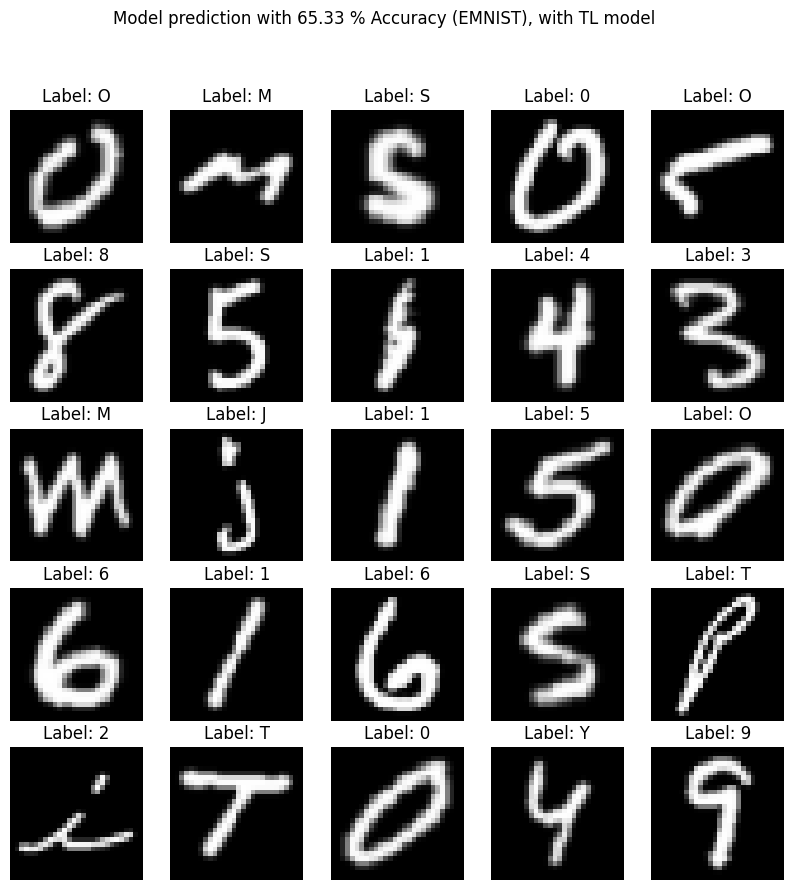

In [69]:
# Display some random images from the training set
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(emnist_test[i], cmap='gray')
    plt.title(f"Label: {mapped_labels[i]}") 
    plt.axis('off')
    plt.suptitle('Model prediction with {} % Accuracy (EMNIST), with TL model'.format(round((emnist_acc*100),2)))
plt.show()